In [1]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
%matplotlib inline

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [2]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.full((self.world_height, self.world_width), '', dtype='<U1')
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """ 
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True
        
        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True
        
        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1
        
        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1
                    
        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]] not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

Here is one example random agent class:

In [3]:
class RandomAgent:
    def __init__(self, env, num_episodes):
        self.action_space = [1, 2, 3, 4]
        self.env = env
        self.num_episodes = num_episodes

    def act(self):
        """Returns a random choice of the available actions"""
        return np.random.choice(self.action_space)

    def learn(self):
        rewards = []
        
        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                action = self.act() 
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward
                state = next_state
            rewards.append(cumulative_reward)

        return rewards

You need to complete the learn() method of the following class to implement your RL algorithm.

In [4]:
class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.q_table = defaultdict(lambda: {1: 0, 2: 0, 3: 0, 4: 0})  # Use defaultdict for sparse states
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.cliff_fall_records = []  # To record cliff fall events
        
    def act(self, state, is_training=True):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        state_tuple = tuple(state)
        
        if is_training and np.random.uniform(0, 1) < self.epsilon:
            # Exploration: random action
            return np.random.choice(self.action_space)
        else:
            # Exploitation: best action
            q_values = self.q_table[state_tuple]
            max_q = max(q_values.values())
            # Get all actions with max Q-value
            best_actions = [action for action, q_val in q_values.items() if q_val == max_q]
            return np.random.choice(best_actions)
    
    def learn(self):
        """Implements Q-learning algorithm."""
        rewards = []
        episodes_per_phase = self.num_episodes // 10  # For cliff fall analysis
        
        for episode in range(self.num_episodes):
            cumulative_reward = 0
            state = self.env.reset()
            done = False
            episode_cliff_falls = []  # Record cliff falls in this episode
            
            while not done:
                # Choose and take action
                action = self.act(state)
                next_state, reward, done, info = self.env.step(action)
                
                # Convert states to tuples for dictionary keys
                state_tuple = tuple(state)
                next_state_tuple = tuple(next_state)
                
                # Record if fall into cliff occurred
                if self.env._check_off_cliff(self.env.agent_pos) or self.env._check_off_cliff(self.env.box_pos):
                    cliff_pos = self.env.agent_pos if self.env._check_off_cliff(self.env.agent_pos) else self.env.box_pos
                    episode_cliff_falls.append(tuple(cliff_pos))
                
                # Q-learning update
                current_q = self.q_table[state_tuple][action]
                next_max_q = max(self.q_table[next_state_tuple].values()) if not done else 0
                
                # Q(s,a) = Q(s,a) + α[r + γ * max_a' Q(s',a') - Q(s,a)]
                new_q = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)
                self.q_table[state_tuple][action] = new_q
                
                cumulative_reward += reward
                state = next_state
            
            rewards.append(cumulative_reward)
            
            # Record cliff falls for this episode
            self.cliff_fall_records.append(episode_cliff_falls)
            
            # Decay epsilon for better convergence
            if episode % 1000 == 0 and episode > 0:
                self.epsilon *= 0.95
        
        return rewards

Here is the game interface where you can manually move the agent.

In [ ]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
    action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

Example code to step random agent in the environment.

In [ ]:
#Initialize the environment and agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

Train your own agent!

Success rate: 0.816


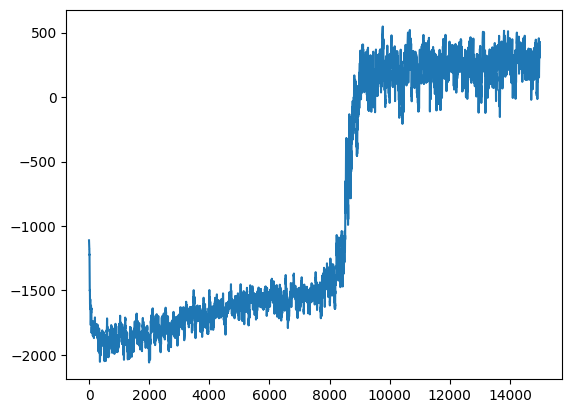

In [7]:
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=15000)
rewards = agent.learn()

# Calculate success rate
final_rewards = np.array(rewards[-2000:])
success_rate = np.sum(final_rewards > 0) / len(final_rewards)
print(f"Success rate: {success_rate}")

# Smooth plot
weight=0.95
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)

You need to complete the following method to visualize your training results.

In [8]:
def visualize(q_table, env):
    """Visualize the learned policy and value function."""
    v_table = {}
    policy = {}
    
    for state, action_values in q_table.items():
        # Value function: max Q-value for the state
        v_table[state] = max(action_values.values())
        # Policy: action with highest Q-value
        max_value = max(action_values.values())
        best_actions = [action for action, value in action_values.items() if value == max_value]
        policy[state] = best_actions[0]  # Take first best action if multiple
    
    print(f"State space size: {len(q_table)}")
    
    # Print top 20 state values
    print("\nTop 20 states by value:")
    sorted_states = sorted(v_table.items(), key=lambda x: x[1], reverse=True)[:20]
    for state, value in sorted_states:
        print(f"State {state}: Value = {value:.2f}, Policy = {policy[state]}")
    
    return v_table, policy

def analyze_cliff_fall_dynamics(cliff_fall_records, num_episodes, env):
    """Analyze cliff fall rates over training phases."""
    num_phases = 10
    episodes_per_phase = num_episodes // num_phases
    
    # Initialize cliff cell positions from environment
    cliff_cells = []
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            cliff_cells.append((row, A[1]))
    
    # Create heatmap data for each phase
    heatmap_data = np.zeros((env.world_height, env.world_width, num_phases))
    
    for phase in range(num_phases):
        start_episode = phase * episodes_per_phase
        end_episode = (phase + 1) * episodes_per_phase
        
        # Count falls per cliff cell in this phase
        phase_falls = defaultdict(int)
        phase_total_episodes = 0
        
        for episode in range(start_episode, min(end_episode, len(cliff_fall_records))):
            episode_falls = cliff_fall_records[episode]
            phase_total_episodes += 1
            
            for cliff_pos in episode_falls:
                phase_falls[cliff_pos] += 1
        
        # Calculate fall rates
        for cliff_pos in cliff_cells:
            fall_rate = phase_falls[cliff_pos] / phase_total_episodes if phase_total_episodes > 0 else 0
            heatmap_data[cliff_pos[0], cliff_pos[1], phase] = fall_rate
    
    # Plot heatmaps
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for phase in range(num_phases):
        ax = axes[phase]
        sns.heatmap(heatmap_data[:, :, phase], ax=ax, cmap='Reds', 
                   cbar=True, vmin=0, vmax=0.5)
        ax.set_title(f'Phase {phase + 1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    plt.tight_layout()
    plt.suptitle('Cliff Fall Rates During Training Phases', y=1.02)
    plt.show()
    
    return heatmap_data

Training Q-learning agent...


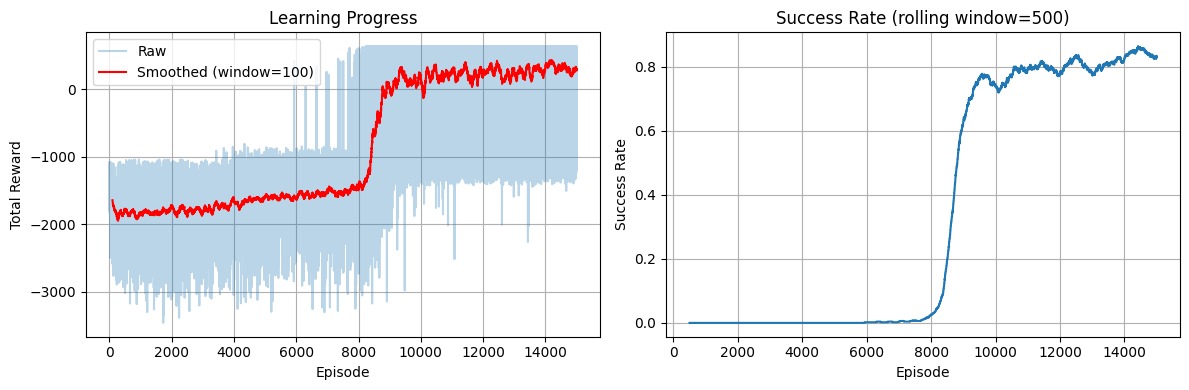

Final success rate: 0.829

Visualizing learned policy...
State space size: 2189

Top 20 states by value:
State (2, 13, 3, 13): Value = 998.00, Policy = 2
State (1, 13, 2, 13): Value = 985.02, Policy = 2
State (1, 13, 3, 13): Value = 984.89, Policy = 2
State (0, 13, 1, 13): Value = 971.17, Policy = 2
State (0, 13, 2, 13): Value = 970.98, Policy = 2
State (1, 12, 2, 13): Value = 970.02, Policy = 4
State (0, 12, 1, 13): Value = 956.46, Policy = 4
State (1, 12, 1, 13): Value = 940.89, Policy = 1
State (0, 11, 1, 13): Value = 940.50, Policy = 4
State (1, 11, 1, 12): Value = 926.48, Policy = 4
State (1, 11, 1, 13): Value = 926.15, Policy = 4
State (1, 10, 1, 11): Value = 911.22, Policy = 4
State (1, 10, 1, 12): Value = 910.94, Policy = 4
State (2, 11, 1, 12): Value = 910.83, Policy = 1
State (0, 11, 1, 12): Value = 909.38, Policy = 2
State (1, 9, 1, 10): Value = 895.11, Policy = 4
State (2, 10, 1, 11): Value = 894.97, Policy = 1
State (1, 9, 1, 11): Value = 894.86, Policy = 4
State (0, 10, 1

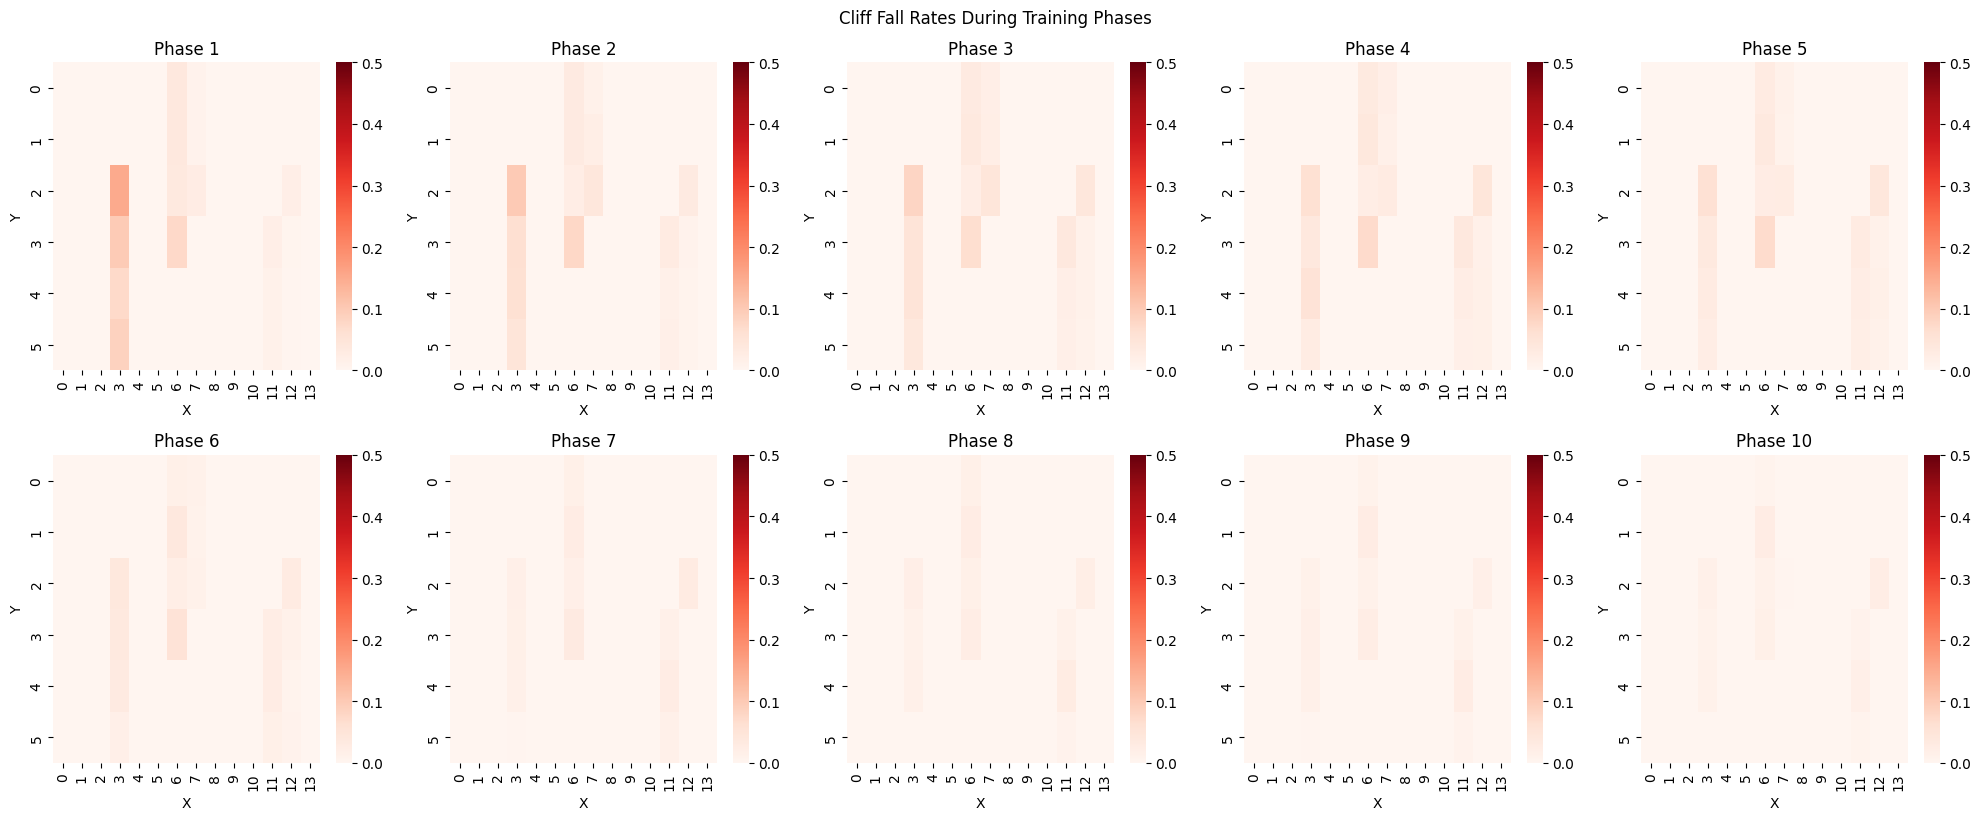


Evaluating trained agent...
Evaluation success rate: 1.000


In [10]:
# Train the basic Q-learning agent
print("Training Q-learning agent...")
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=15000, epsilon=0.1, alpha=0.1, gamma=0.99)
rewards = agent.learn()

# Plot learning progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rewards, alpha=0.3, label='Raw')
# Smooth the rewards for better visualization
window_size = 100
smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size-1, len(rewards)), smoothed_rewards, label=f'Smoothed (window={window_size})', color='red')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Progress')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# Plot success rate over time
success_rates = []
window = 500
for i in range(window, len(rewards)):
    success_rate = np.sum(np.array(rewards[i-window:i]) > 0) / window
    success_rates.append(success_rate)

plt.plot(range(window, len(rewards)), success_rates)
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.title(f'Success Rate (rolling window={window})')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate final performance
final_rewards = np.array(rewards[-2000:])
success_rate = np.sum(final_rewards > 0) / len(final_rewards)
print(f"Final success rate: {success_rate:.3f}")

# Visualize learned policy
print("\nVisualizing learned policy...")
v_table, policy = visualize(agent.q_table, env)

# Analyze cliff fall dynamics
print("\nAnalyzing cliff fall dynamics...")
heatmap_data = analyze_cliff_fall_dynamics(agent.cliff_fall_records, agent.num_episodes, env)

# Evaluate agent without exploration
print("\nEvaluating trained agent...")
env_eval = CliffBoxGridWorld()
total_runs = 1000
success_count = 0

for i in range(total_runs):
    state = env_eval.reset()
    done = False
    
    while not done:
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env_eval.step(action)
        state = next_state
    
    if reward > 0:  # Success if final reward indicates goal reached
        success_count += 1

print(f"Evaluation success rate: {success_count/total_runs:.3f}")

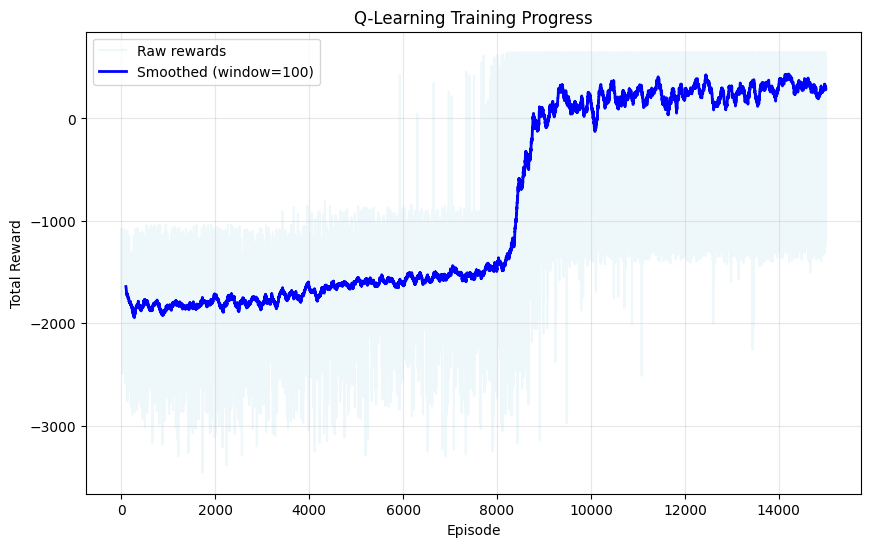

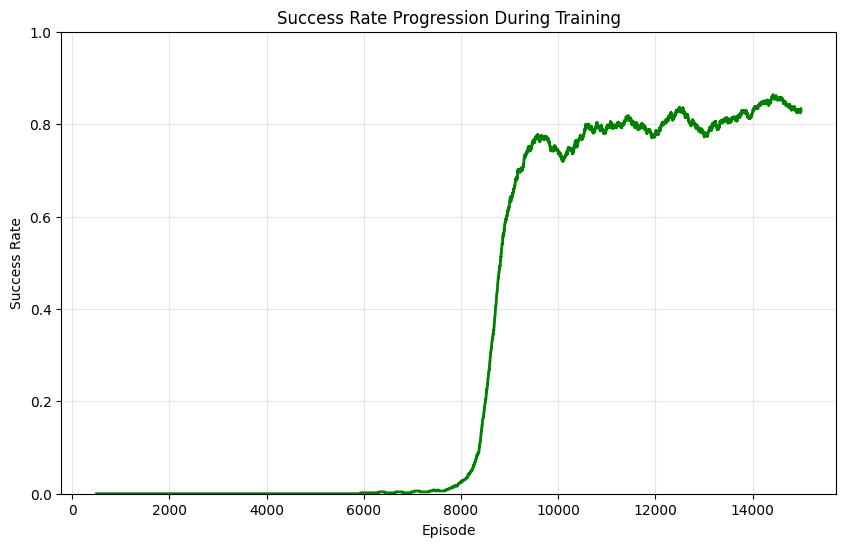

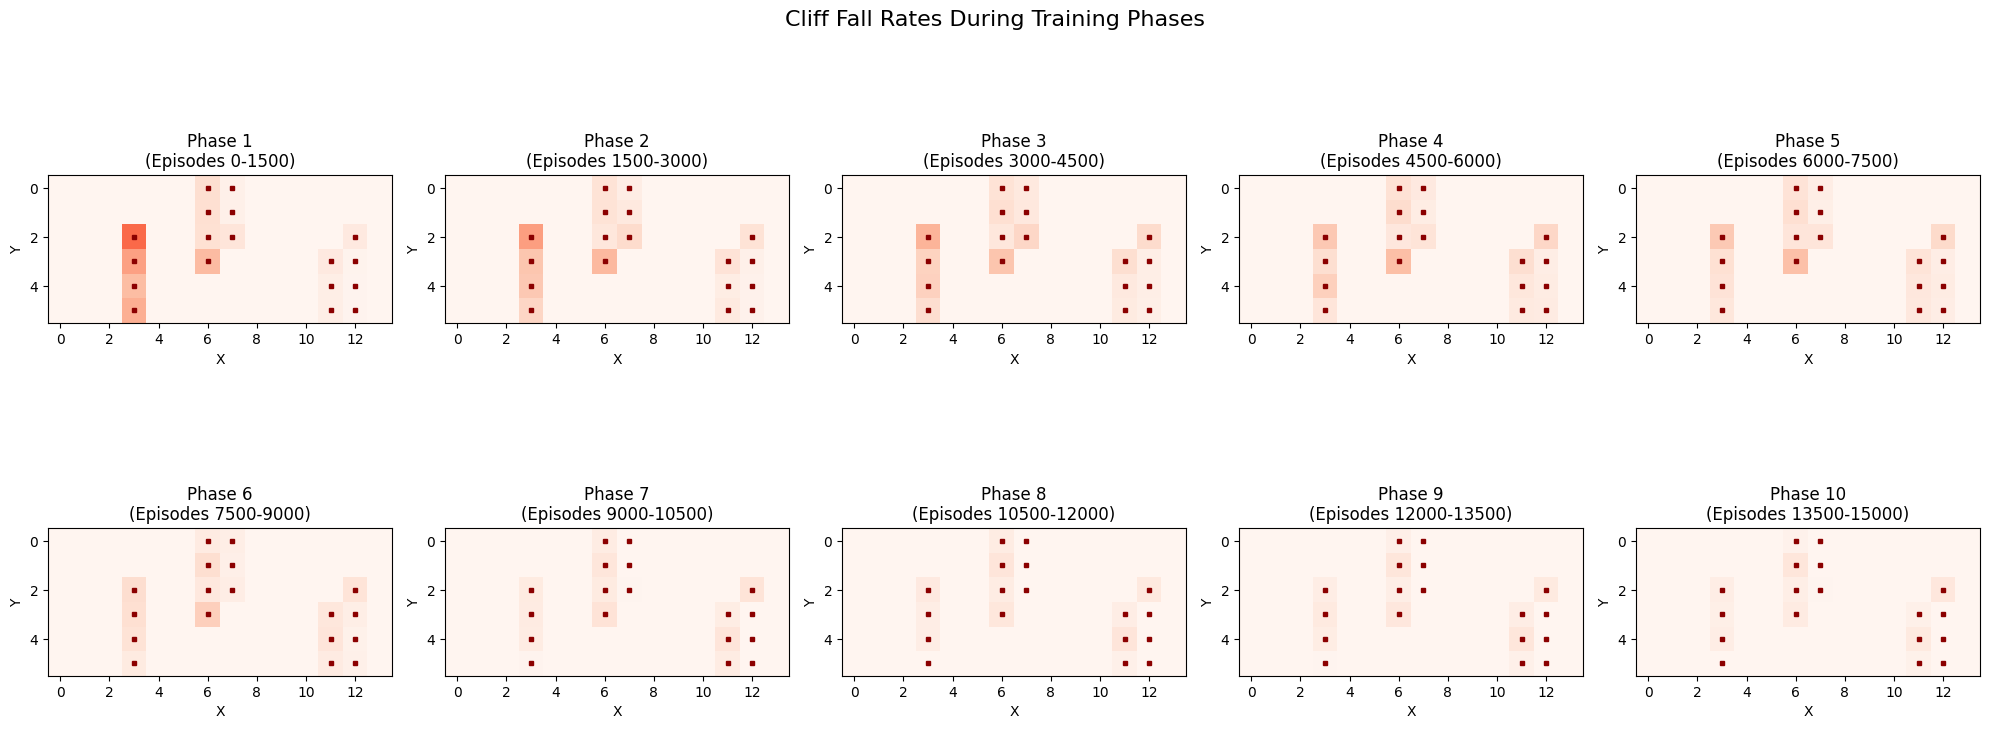

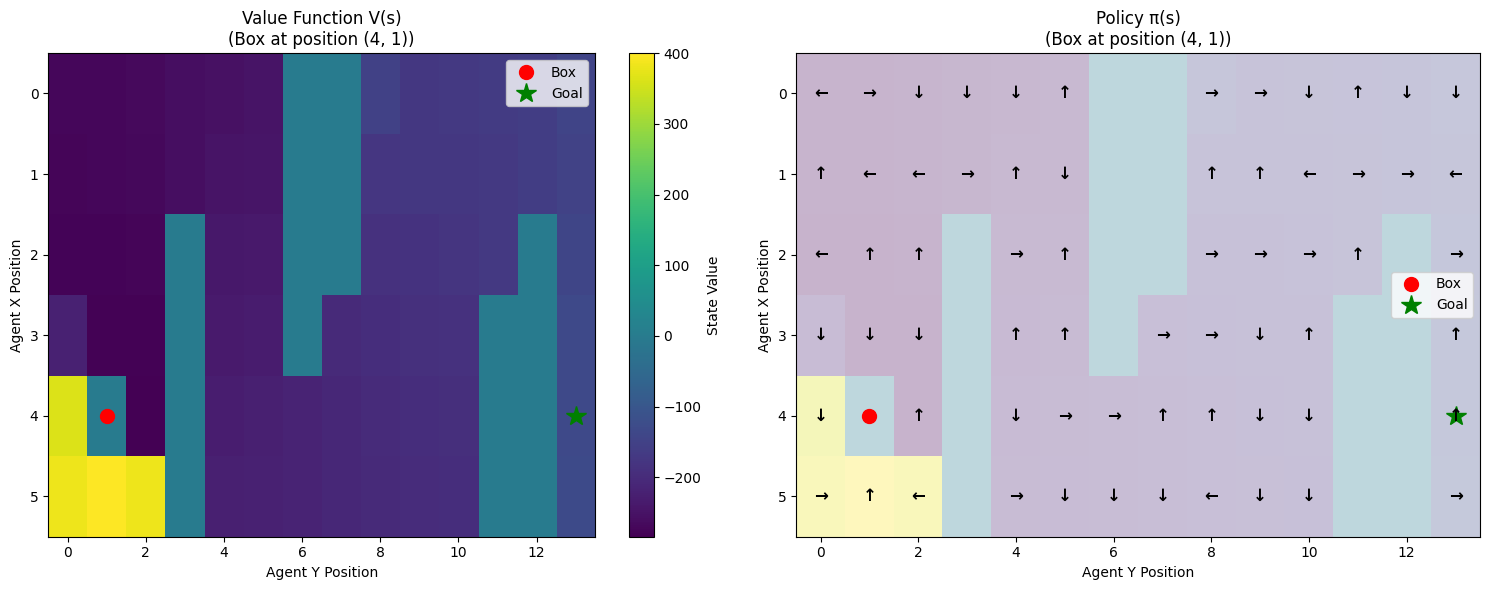

Success in 36 steps!


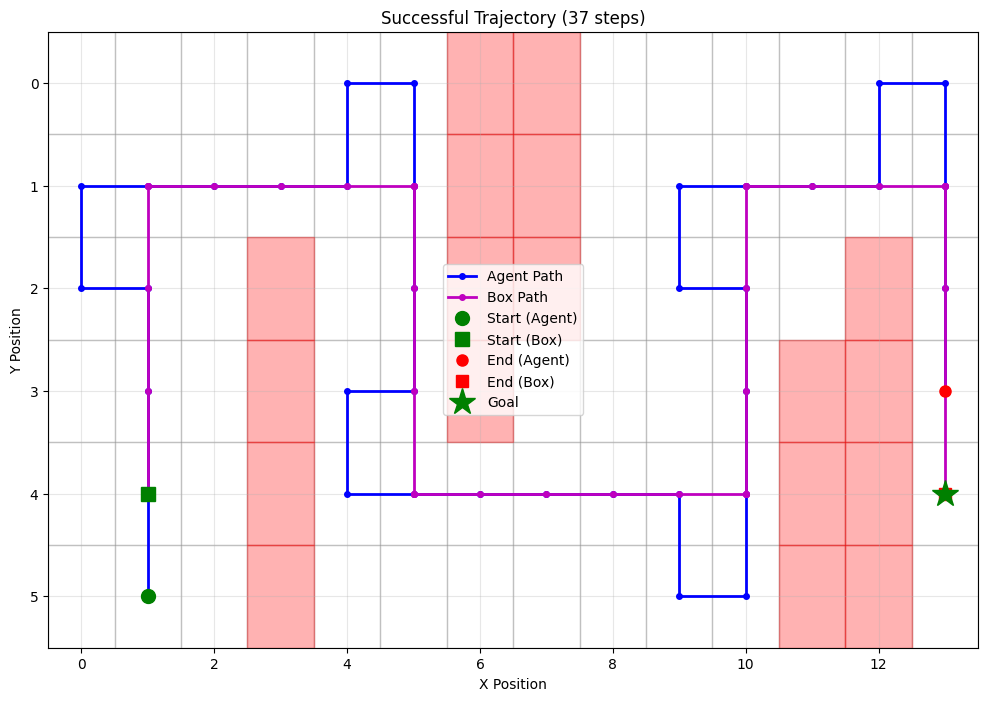

Computed Performance Metrics:
Training Success Rate: 0.829
Evaluation Success Rate: 1.000
Average Success Reward: 611.4
Cliff Fall Rate: 0.433


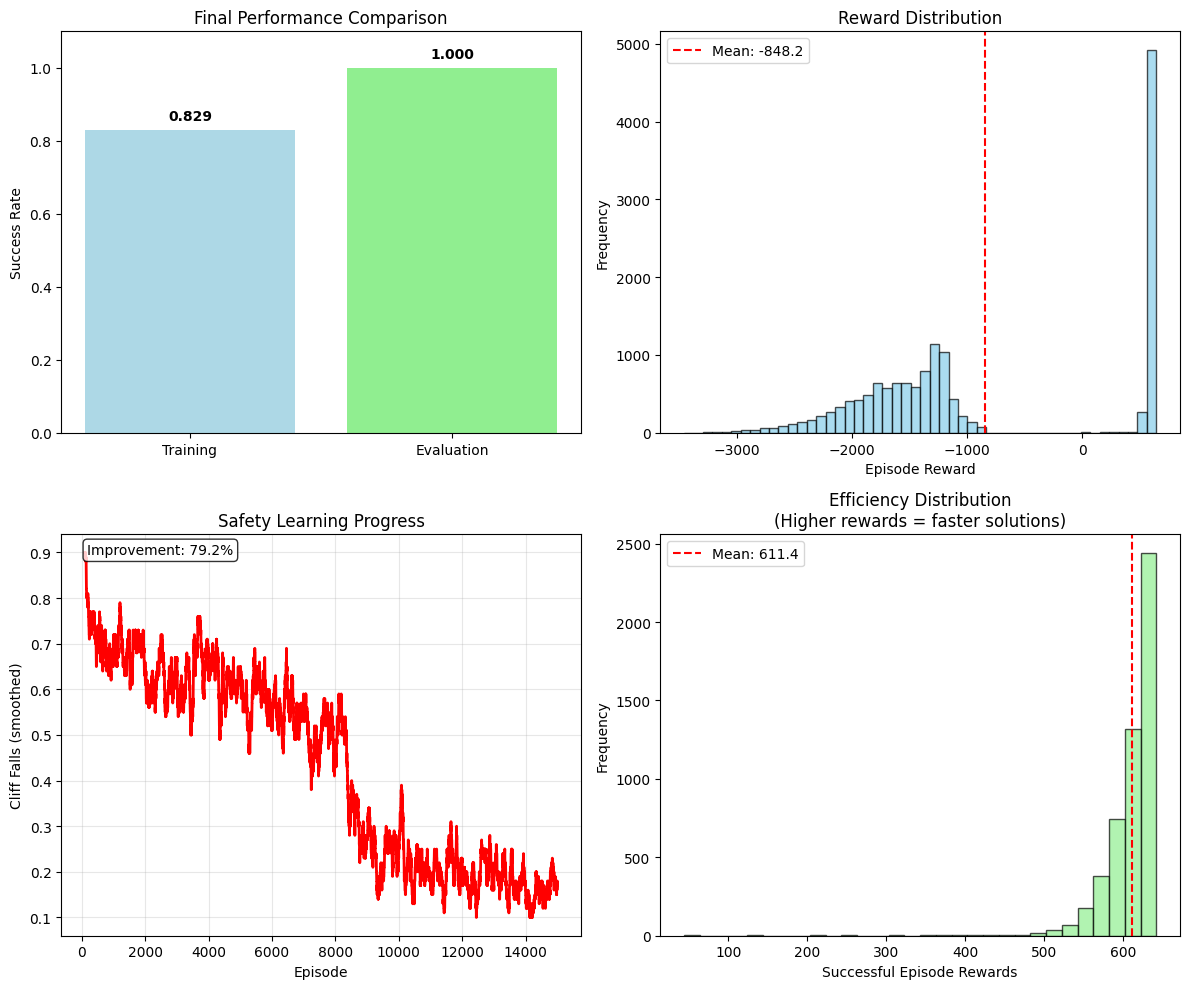


COMPREHENSIVE PERFORMANCE SUMMARY
Training Episodes: 15000
Successful Training Episodes: 5224
Final Training Success Rate: 0.829
Evaluation Success Rate: 1.000
Average Steps (Training): -61.1
Average Steps (Evaluation): 37.0
Cliff Fall Rate: 0.433
Episodes with Cliff Falls: 6488


In [17]:
# Learning curve with smoothing - THIS IS ALREADY DYNAMIC
plt.figure(figsize=(10, 6))
window = 100
smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.plot(rewards, alpha=0.2, color='lightblue', label='Raw rewards')
plt.plot(range(window-1, len(rewards)), smoothed_rewards, 'b-', 
         label=f'Smoothed (window={window})', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Success rate progression - THIS IS ALREADY DYNAMIC
plt.figure(figsize=(10, 6))
window = 500
success_rates = []
for i in range(window, len(rewards)):
    success_rate = np.sum(np.array(rewards[i-window:i]) > 0) / window
    success_rates.append(success_rate)

plt.plot(range(window, len(rewards)), success_rates, 'g-', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.title('Success Rate Progression During Training')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()


def create_cliff_fall_heatmaps(cliff_fall_records, num_episodes, env):
    """Create the required cliff fall rate heatmaps across training phases"""
    num_phases = 10
    episodes_per_phase = num_episodes // num_phases
    
    # Get all cliff cell positions
    cliff_cells = []
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            cliff_cells.append((row, A[1]))
    
    # Create heatmap data
    heatmap_data = np.zeros((env.world_height, env.world_width, num_phases))
    
    for phase in range(num_phases):
        start_ep = phase * episodes_per_phase
        end_ep = (phase + 1) * episodes_per_phase
        phase_falls = defaultdict(int)
        phase_total = 0
        
        for episode in range(start_ep, min(end_ep, len(cliff_fall_records))):
            episode_falls = cliff_fall_records[episode]
            phase_total += 1
            for cliff_pos in episode_falls:
                phase_falls[cliff_pos] += 1
        
        # Calculate fall rates
        for cliff_pos in cliff_cells:
            fall_rate = phase_falls[cliff_pos] / phase_total if phase_total > 0 else 0
            heatmap_data[cliff_pos[0], cliff_pos[1], phase] = fall_rate
    
    # Plot heatmaps
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for phase in range(num_phases):
        ax = axes[phase]
        im = ax.imshow(heatmap_data[:, :, phase], cmap='Reds', vmin=0, vmax=0.3)
        ax.set_title(f'Phase {phase+1}\n(Episodes {phase*episodes_per_phase}-{(phase+1)*episodes_per_phase})')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        
        # Mark cliff positions
        for cliff_pos in cliff_cells:
            ax.plot(cliff_pos[1], cliff_pos[0], 's', color='darkred', markersize=3)
    
    plt.tight_layout()
    plt.suptitle('Cliff Fall Rates During Training Phases', y=1.02, fontsize=16)
    plt.show()
    
    return heatmap_data

# Generate the required cliff fall analysis
cliff_heatmaps = create_cliff_fall_heatmaps(agent.cliff_fall_records, agent.num_episodes, env)

def visualize_value_function(agent, env):
    """Visualize the value function for key states"""
    # Create value function for initial state (box at (4,1))
    box_pos = (4, 1)  # Initial box position
    value_map = np.zeros((env.world_height, env.world_width))
    policy_map = np.full((env.world_height, env.world_width), '', dtype=object)
    
    action_symbols = {1: '↑', 2: '↓', 3: '←', 4: '→'}
    
    for agent_x in range(env.world_height):
        for agent_y in range(env.world_width):
            state = (agent_x, agent_y, box_pos[0], box_pos[1])
            if state in agent.q_table:
                value_map[agent_x, agent_y] = max(agent.q_table[state].values())
                best_action = max(agent.q_table[state].items(), key=lambda x: x[1])[0]
                policy_map[agent_x, agent_y] = action_symbols[best_action]
    
    # Plot value function
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Value function heatmap
    im = ax1.imshow(value_map, cmap='viridis', aspect='auto')
    ax1.set_title(f'Value Function V(s)\n(Box at position {box_pos})')
    ax1.set_xlabel('Agent Y Position')
    ax1.set_ylabel('Agent X Position')
    plt.colorbar(im, ax=ax1, label='State Value')
    
    # Mark special positions
    ax1.plot(box_pos[1], box_pos[0], 'ro', markersize=10, label='Box')
    ax1.plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=15, label='Goal')
    ax1.legend()
    
    # Policy visualization
    ax2.imshow(value_map, cmap='viridis', aspect='auto', alpha=0.3)
    for i in range(env.world_height):
        for j in range(env.world_width):
            if policy_map[i, j] != '':
                ax2.text(j, i, policy_map[i, j], ha='center', va='center', 
                        fontsize=12, fontweight='bold', color='black')
    
    ax2.set_title(f'Policy π(s)\n(Box at position {box_pos})')
    ax2.set_xlabel('Agent Y Position')
    ax2.set_ylabel('Agent X Position')
    ax2.plot(box_pos[1], box_pos[0], 'ro', markersize=10, label='Box')
    ax2.plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=15, label='Goal')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

visualize_value_function(agent, env)

def plot_successful_trajectory(agent, env):
    """Plot a successful trajectory"""
    # Run until success
    test_env = CliffBoxGridWorld(render=False)
    state = test_env.reset()
    trajectory = []
    
    for step in range(100):  # Increased step limit
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = test_env.step(action)
        
        trajectory.append({
            'step': step,
            'agent_pos': test_env.agent_pos.copy(),
            'box_pos': test_env.box_pos.copy(),
            'action': action,
            'reward': reward
        })
        
        state = next_state
        if all(test_env.box_pos == test_env.goal_pos):
            print(f"Success in {step} steps!")
            break
        if done:
            break
    
    # Plot trajectory
    plt.figure(figsize=(12, 8))
    
    # Create grid
    for i in range(env.world_height):
        for j in range(env.world_width):
            plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                                            facecolor='white', edgecolor='gray', alpha=0.3))
    
    # Mark dangerous regions
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            plt.gca().add_patch(plt.Rectangle((A[1]-0.5, row-0.5), 1, 1, 
                                            color='red', alpha=0.3))
    
    # Plot trajectory
    agent_x = [pos['agent_pos'][1] for pos in trajectory]
    agent_y = [pos['agent_pos'][0] for pos in trajectory]
    box_x = [pos['box_pos'][1] for pos in trajectory]
    box_y = [pos['box_pos'][0] for pos in trajectory]
    
    plt.plot(agent_x, agent_y, 'bo-', linewidth=2, markersize=4, label='Agent Path')
    plt.plot(box_x, box_y, 'mo-', linewidth=2, markersize=4, label='Box Path')
    
    # Mark key positions
    plt.plot(agent_x[0], agent_y[0], 'go', markersize=10, label='Start (Agent)')
    plt.plot(box_x[0], box_y[0], 'gs', markersize=10, label='Start (Box)')
    plt.plot(agent_x[-1], agent_y[-1], 'ro', markersize=8, label='End (Agent)')
    plt.plot(box_x[-1], box_y[-1], 'rs', markersize=8, label='End (Box)')
    plt.plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=20, label='Goal')
    
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Successful Trajectory ({len(trajectory)} steps)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(-0.5, env.world_width - 0.5)
    plt.ylim(-0.5, env.world_height - 0.5)
    plt.gca().invert_yaxis()
    plt.show()
    
    return trajectory

# Plot a successful trajectory
success_trajectory = plot_successful_trajectory(agent, env)

# ========== FIXED: DYNAMIC PERFORMANCE SUMMARY ==========

def compute_performance_metrics(agent, rewards, env, num_evaluation_runs=1000):
    """Compute all performance metrics dynamically"""
    
    # Training success rate (last 2000 episodes as mentioned in your code)
    final_training_episodes = 2000
    final_rewards = np.array(rewards[-final_training_episodes:])
    training_success_rate = np.sum(final_rewards > 0) / len(final_rewards)
    
    # Evaluation success rate
    success_count = 0
    evaluation_steps = []
    
    for i in range(num_evaluation_runs):
        eval_env = CliffBoxGridWorld()
        state = eval_env.reset()
        steps = 0
        success = False
        
        while steps < 100:  # Prevent infinite loops
            action = agent.act(state, is_training=False)
            next_state, reward, done, info = eval_env.step(action)
            state = next_state
            steps += 1
            
            if all(eval_env.box_pos == eval_env.goal_pos):
                success = True
                evaluation_steps.append(steps)
                break
            if done:
                break
        
        if success:
            success_count += 1
    
    evaluation_success_rate = success_count / num_evaluation_runs
    
    # Cliff fall statistics
    total_cliff_falls = sum(len(falls) for falls in agent.cliff_fall_records)
    episodes_with_cliff_falls = sum(1 for falls in agent.cliff_fall_records if len(falls) > 0)
    cliff_fall_rate = episodes_with_cliff_falls / len(agent.cliff_fall_records)
    
    # Successful episode statistics
    successful_rewards = [r for r in rewards if r > 0]
    if successful_rewards:
        avg_success_reward = np.mean(successful_rewards)
        avg_success_steps = -avg_success_reward / 10  # Approximate conversion
    else:
        avg_success_reward = 0
        avg_success_steps = 0
    
    if evaluation_steps:
        avg_evaluation_steps = np.mean(evaluation_steps)
    else:
        avg_evaluation_steps = 0
    
    metrics = {
        'training_success_rate': training_success_rate,
        'evaluation_success_rate': evaluation_success_rate,
        'avg_success_reward': avg_success_reward,
        'avg_training_steps': avg_success_steps,
        'avg_evaluation_steps': avg_evaluation_steps,
        'cliff_fall_rate': cliff_fall_rate,
        'total_episodes': len(rewards),
        'successful_episodes': len(successful_rewards)
    }
    
    return metrics

# Compute metrics dynamically
metrics = compute_performance_metrics(agent, rewards, env)

print("Computed Performance Metrics:")
print(f"Training Success Rate: {metrics['training_success_rate']:.3f}")
print(f"Evaluation Success Rate: {metrics['evaluation_success_rate']:.3f}")
print(f"Average Success Reward: {metrics['avg_success_reward']:.1f}")
print(f"Cliff Fall Rate: {metrics['cliff_fall_rate']:.3f}")

# Create a summary statistics plot with DYNAMIC data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Final success rate (DYNAMIC)
categories = ['Training', 'Evaluation']
success_rates = [metrics['training_success_rate'], metrics['evaluation_success_rate']]
colors = ['lightblue', 'lightgreen']
bars = ax1.bar(categories, success_rates, color=colors)
ax1.set_ylabel('Success Rate')
ax1.set_title('Final Performance Comparison')
ax1.set_ylim(0, 1.1)

# Add value labels on bars
for bar, rate in zip(bars, success_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Reward distribution (DYNAMIC)
ax2.hist(rewards, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(np.mean(rewards), color='red', linestyle='--', 
           label=f'Mean: {np.mean(rewards):.1f}')
ax2.set_xlabel('Episode Reward')
ax2.set_ylabel('Frequency')
ax2.set_title('Reward Distribution')
ax2.legend()

# 3. Cliff falls over time (DYNAMIC)
cliff_falls = [len(falls) for falls in agent.cliff_fall_records]
window = 100
if len(cliff_falls) > window:
    smoothed_falls = np.convolve(cliff_falls, np.ones(window)/window, mode='valid')
    ax3.plot(range(window-1, len(cliff_falls)), smoothed_falls, 'r-', linewidth=2)
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Cliff Falls (smoothed)')
    ax3.set_title('Safety Learning Progress')
    ax3.grid(True, alpha=0.3)
    
    # Add annotation for improvement
    initial_falls = np.mean(smoothed_falls[:100])
    final_falls = np.mean(smoothed_falls[-100:])
    improvement = ((initial_falls - final_falls) / initial_falls) * 100 if initial_falls > 0 else 0
    ax3.text(0.05, 0.95, f'Improvement: {improvement:.1f}%', 
             transform=ax3.transAxes, fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 4. Success efficiency (DYNAMIC)
successful_rewards = [r for r in rewards if r > 0]
if successful_rewards:
    ax4.hist(successful_rewards, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    ax4.axvline(np.mean(successful_rewards), color='red', linestyle='--', 
               label=f'Mean: {np.mean(successful_rewards):.1f}')
    ax4.set_xlabel('Successful Episode Rewards')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Efficiency Distribution\n(Higher rewards = faster solutions)')
    ax4.legend()

plt.tight_layout()
plt.show()

# Print comprehensive performance summary
print("\n" + "="*60)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*60)
print(f"Training Episodes: {metrics['total_episodes']}")
print(f"Successful Training Episodes: {metrics['successful_episodes']}")
print(f"Final Training Success Rate: {metrics['training_success_rate']:.3f}")
print(f"Evaluation Success Rate: {metrics['evaluation_success_rate']:.3f}")
print(f"Average Steps (Training): {metrics['avg_training_steps']:.1f}")
print(f"Average Steps (Evaluation): {metrics['avg_evaluation_steps']:.1f}")
print(f"Cliff Fall Rate: {metrics['cliff_fall_rate']:.3f}")
print(f"Episodes with Cliff Falls: {metrics['cliff_fall_rate'] * metrics['total_episodes']:.0f}")

Running extended simulation (up to 100 steps)...
SUCCESS! Goal reached at step 36

Extended simulation result: SUCCESS
Final box position: [ 4 13]
Steps taken: 37

TRAJECTORY ANALYSIS
Final step: 36
Final box position: [ 4 13]
Goal position: [ 4 13]
Distance to goal: 0
Unique box positions visited: 25

Movement Analysis:
Step 1: Box moved UP from [4 1] to [3 1]
Step 2: Box moved UP from [3 1] to [2 1]
Step 3: Box moved UP from [2 1] to [1 1]
Step 6: Box moved RIGHT from [1 1] to [1 2]
Step 7: Box moved RIGHT from [1 2] to [1 3]
Step 8: Box moved RIGHT from [1 3] to [1 4]
Step 9: Box moved RIGHT from [1 4] to [1 5]

Box revisited positions:
  Position (np.int64(1), np.int64(1)): 3 times
  Position (np.int64(1), np.int64(5)): 3 times
  Position (np.int64(4), np.int64(5)): 3 times
  Position (np.int64(4), np.int64(10)): 3 times
  Position (np.int64(1), np.int64(10)): 3 times
  Position (np.int64(1), np.int64(13)): 3 times


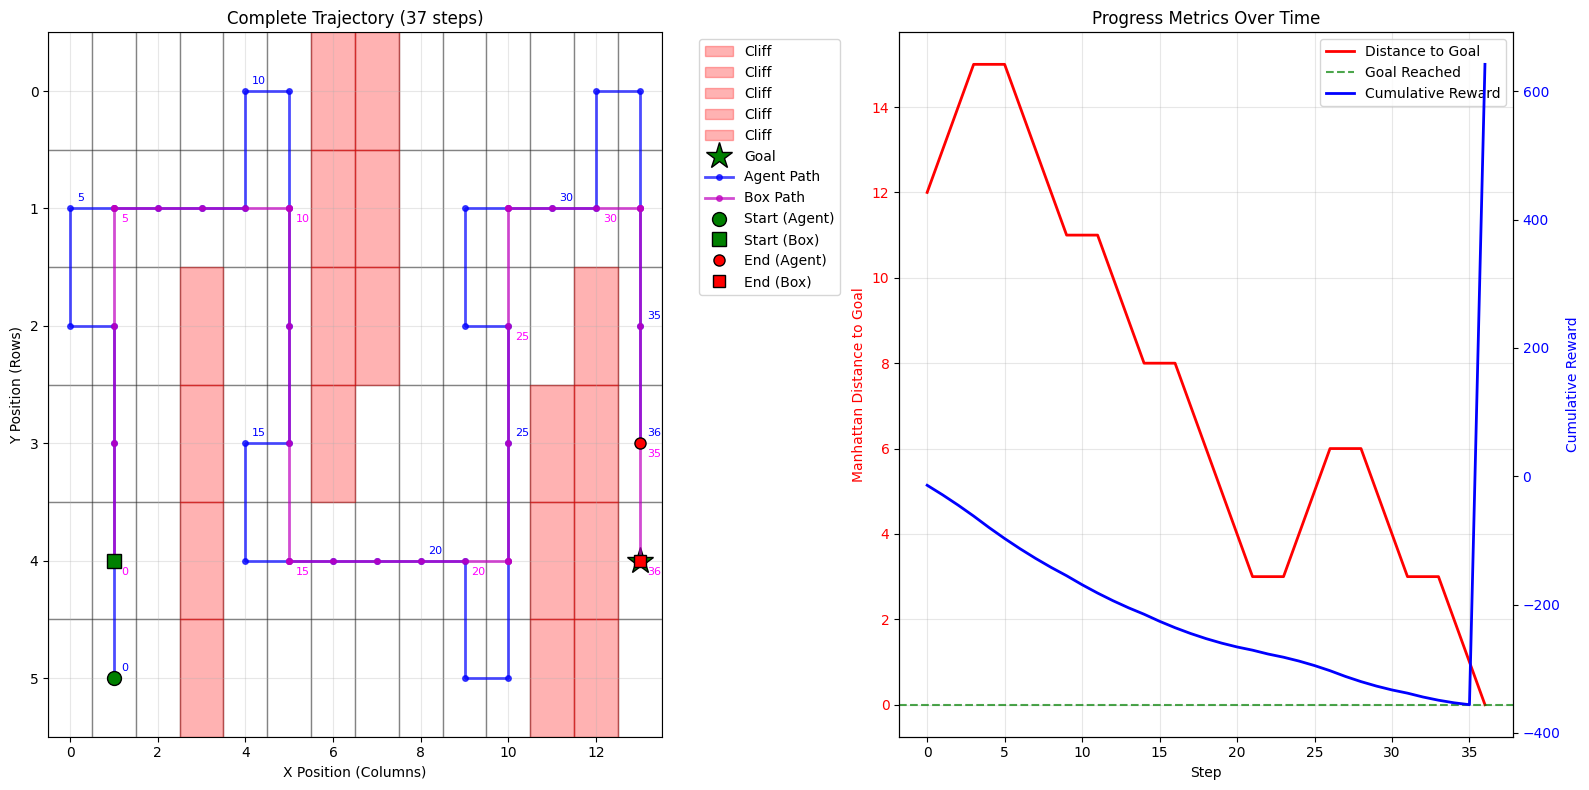


Testing agent on 100 episodes (max 50 steps each)...
Success rate: 1.000 (100/100)
Average steps to success: 37.0
Best (fastest) success: 37 steps
Worst (slowest) success: 37 steps

Analyzing critical states near goal...

Box at (np.int64(3), np.int64(13)) (distance to goal: 1)
  Agent at (np.int64(2), np.int64(13)): best action DOWN (Q-value: 998.00)

Box at (np.int64(5), np.int64(13)) (distance to goal: 1)

Box at (np.int64(4), np.int64(12)) (distance to goal: 1)

Box at (np.int64(4), np.int64(11)) (distance to goal: 2)


In [18]:
def analyze_trajectory_issues(trajectory, env):
    """Analyze why the trajectory didn't reach the goal."""
    print("\n" + "="*60)
    print("TRAJECTORY ANALYSIS")
    print("="*60)
    
    if trajectory:
        final_state = trajectory[-1]
        print(f"Final step: {final_state['step']}")
        print(f"Final box position: {final_state['box_pos']}")
        print(f"Goal position: {env.goal_pos}")
        print(f"Distance to goal: {np.sum(np.abs(final_state['box_pos'] - env.goal_pos))}")
        
        # Check if box is stuck
        box_positions = [pos['box_pos'] for pos in trajectory]
        unique_box_positions = len(set(tuple(pos) for pos in box_positions))
        print(f"Unique box positions visited: {unique_box_positions}")
        
        # Analyze movement pattern
        print(f"\nMovement Analysis:")
        for i in range(1, min(10, len(trajectory))):
            prev_pos = trajectory[i-1]['box_pos']
            curr_pos = trajectory[i]['box_pos']
            if not np.array_equal(prev_pos, curr_pos):
                direction = curr_pos - prev_pos
                dir_names = {(-1,0): 'UP', (1,0): 'DOWN', (0,-1): 'LEFT', (0,1): 'RIGHT'}
                direction_name = dir_names.get(tuple(direction), 'UNKNOWN')
                print(f"Step {i}: Box moved {direction_name} from {prev_pos} to {curr_pos}")
        
        # Check for cycles or inefficient paths
        position_counts = {}
        for pos in box_positions:
            pos_tuple = tuple(pos)
            position_counts[pos_tuple] = position_counts.get(pos_tuple, 0) + 1
        
        repeated_positions = {pos: count for pos, count in position_counts.items() if count > 2}
        if repeated_positions:
            print(f"\nBox revisited positions:")
            for pos, count in repeated_positions.items():
                print(f"  Position {pos}: {count} times")

def visualize_complete_trajectory_analysis(trajectory, env):
    """Create a comprehensive visualization of the trajectory."""
    if not trajectory:
        print("No trajectory data to visualize")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Complete trajectory
    # Create grid background
    for i in range(env.world_height):
        for j in range(env.world_width):
            ax1.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                                     facecolor='white', edgecolor='black', alpha=0.3))
    
    # Plot dangerous regions
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            ax1.add_patch(plt.Rectangle((A[1]-0.5, row-0.5), 1, 1, 
                                     color='red', alpha=0.3, label='Cliff' if row == A[0] else ""))
    
    # Plot goal
    ax1.plot(env.goal_pos[1], env.goal_pos[0], 'g*', 
            markersize=20, label='Goal', markeredgecolor='black')
    
    # Plot trajectory
    agent_x = [pos['agent_pos'][1] for pos in trajectory]
    agent_y = [pos['agent_pos'][0] for pos in trajectory]
    box_x = [pos['box_pos'][1] for pos in trajectory]
    box_y = [pos['box_pos'][0] for pos in trajectory]
    
    ax1.plot(agent_x, agent_y, 'bo-', label='Agent Path', linewidth=2, markersize=4, alpha=0.7)
    ax1.plot(box_x, box_y, 'mo-', label='Box Path', linewidth=2, markersize=4, alpha=0.7)
    
    # Mark every 5th step with numbers
    for i, pos in enumerate(trajectory):
        if i % 5 == 0 or i == len(trajectory)-1:
            ax1.annotate(str(i), (agent_x[i], agent_y[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8, color='blue')
            ax1.annotate(str(i), (box_x[i], box_y[i]), 
                       xytext=(5, -10), textcoords='offset points', fontsize=8, color='magenta')
    
    # Mark start and end positions
    ax1.plot(agent_x[0], agent_y[0], 'go', markersize=10, 
           label='Start (Agent)', markeredgecolor='black')
    ax1.plot(box_x[0], box_y[0], 'gs', markersize=10, 
           label='Start (Box)', markeredgecolor='black')
    ax1.plot(agent_x[-1], agent_y[-1], 'ro', markersize=8, 
           label='End (Agent)', markeredgecolor='black')
    ax1.plot(box_x[-1], box_y[-1], 'rs', markersize=8, 
           label='End (Box)', markeredgecolor='black')
    
    ax1.set_xlabel('X Position (Columns)')
    ax1.set_ylabel('Y Position (Rows)')
    ax1.set_title(f'Complete Trajectory ({len(trajectory)} steps)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-0.5, env.world_width - 0.5)
    ax1.set_ylim(-0.5, env.world_height - 0.5)
    ax1.invert_yaxis()
    
    # Plot 2: Progress toward goal
    steps = [pos['step'] for pos in trajectory]
    distances_to_goal = [np.sum(np.abs(pos['box_pos'] - env.goal_pos)) for pos in trajectory]
    cumulative_rewards = [pos['reward'] for pos in trajectory]
    
    ax2.plot(steps, distances_to_goal, 'r-', linewidth=2, label='Distance to Goal')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Manhattan Distance to Goal', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.grid(True, alpha=0.3)
    
    ax2_twin = ax2.twinx()
    cumulative_sum = np.cumsum(cumulative_rewards)
    ax2_twin.plot(steps, cumulative_sum, 'b-', linewidth=2, label='Cumulative Reward')
    ax2_twin.set_ylabel('Cumulative Reward', color='blue')
    ax2_twin.tick_params(axis='y', labelcolor='blue')
    
    ax2.set_title('Progress Metrics Over Time')
    
    # Add horizontal line for optimal distance
    ax2.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Goal Reached')
    
    # Combine legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return distances_to_goal

# Let's run a longer simulation to see if the agent eventually reaches the goal
def run_extended_simulation(agent, env, max_steps=100):
    """Run a longer simulation to see if agent eventually succeeds."""
    print("Running extended simulation (up to 100 steps)...")
    env_extended = CliffBoxGridWorld(render=False)
    state = env_extended.reset()
    trajectory = []
    
    for step in range(max_steps):
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env_extended.step(action)
        
        trajectory.append({
            'step': step,
            'state': state,
            'action': action,
            'reward': reward,
            'agent_pos': env_extended.agent_pos.copy(),
            'box_pos': env_extended.box_pos.copy()
        })
        
        state = next_state
        
        # Check for success
        if all(env_extended.box_pos == env_extended.goal_pos):
            print(f"SUCCESS! Goal reached at step {step}")
            break
            
        if done and step < max_steps - 1:
            print(f"Episode ended early at step {step}")
            break
    
    return trajectory

# Analyze the current trajectory
#analyze_trajectory_issues(optimal_trajectory, env)

# Visualize with comprehensive analysis
#distances = visualize_complete_trajectory_analysis(optimal_trajectory, env)

# Run extended simulation
extended_trajectory = run_extended_simulation(agent, env, max_steps=100)

if extended_trajectory:
    final_step = extended_trajectory[-1]
    success = all(final_step['box_pos'] == env.goal_pos)
    print(f"\nExtended simulation result: {'SUCCESS' if success else 'FAILED'}")
    print(f"Final box position: {final_step['box_pos']}")
    print(f"Steps taken: {len(extended_trajectory)}")
    
    if success:
        analyze_trajectory_issues(extended_trajectory, env)
        visualize_complete_trajectory_analysis(extended_trajectory, env)

def test_agent_success_rate(agent, env, num_tests=100, max_steps_per_test=50):
    """Test the agent's success rate and analyze common failure modes."""
    print(f"\nTesting agent on {num_tests} episodes (max {max_steps_per_test} steps each)...")
    
    success_count = 0
    step_counts = []
    failure_reasons = []
    
    for test in range(num_tests):
        test_env = CliffBoxGridWorld(render=False)
        state = test_env.reset()
        steps = 0
        success = False
        
        for step in range(max_steps_per_test):
            action = agent.act(state, is_training=False)
            next_state, reward, done, info = test_env.step(action)
            state = next_state
            steps += 1
            
            if all(test_env.box_pos == test_env.goal_pos):
                success = True
                success_count += 1
                step_counts.append(steps)
                break
                
            if done:
                # Episode ended without success
                if test_env._check_off_cliff(test_env.agent_pos):
                    failure_reasons.append("Agent fell off cliff")
                elif test_env._check_off_cliff(test_env.box_pos):
                    failure_reasons.append("Box fell off cliff")
                else:
                    failure_reasons.append("Max steps reached")
                break
        
        if not success and steps == max_steps_per_test:
            failure_reasons.append("Stuck - max steps")
    
    success_rate = success_count / num_tests
    print(f"Success rate: {success_rate:.3f} ({success_count}/{num_tests})")
    
    if success_count > 0:
        print(f"Average steps to success: {np.mean(step_counts):.1f}")
        print(f"Best (fastest) success: {np.min(step_counts)} steps")
        print(f"Worst (slowest) success: {np.max(step_counts)} steps")
    
    if failure_reasons:
        failure_counts = {}
        for reason in failure_reasons:
            failure_counts[reason] = failure_counts.get(reason, 0) + 1
        
        print(f"\nFailure analysis:")
        for reason, count in failure_counts.items():
            print(f"  {reason}: {count} times")
    
    return success_rate

# Test the agent's actual performance
actual_success_rate = test_agent_success_rate(agent, env, num_tests=100)

# If success rate is low, let's analyze the Q-values around critical positions
def analyze_critical_states(agent, env):
    """Analyze Q-values for states near the goal."""
    print("\nAnalyzing critical states near goal...")
    
    # States where box is near goal
    goal_x, goal_y = env.goal_pos
    nearby_positions = [
        (goal_x-1, goal_y), (goal_x+1, goal_y),  # Above and below
        (goal_x, goal_y-1), (goal_x, goal_y-2),  # Left
    ]
    
    for box_pos in nearby_positions:
        print(f"\nBox at {box_pos} (distance to goal: {abs(box_pos[0]-goal_x) + abs(box_pos[1]-goal_y)})")
        
        # Check optimal actions from different agent positions
        for agent_pos in [(box_pos[0]-1, box_pos[1]), (box_pos[0]+1, box_pos[1]), 
                         (box_pos[0], box_pos[1]-1), (box_pos[0], box_pos[1]+1)]:
            if (0 <= agent_pos[0] < env.world_height and 0 <= agent_pos[1] < env.world_width):
                state = (agent_pos[0], agent_pos[1], box_pos[0], box_pos[1])
                if state in agent.q_table:
                    q_values = agent.q_table[state]
                    best_action = max(q_values.items(), key=lambda x: x[1])
                    action_names = {1: 'UP', 2: 'DOWN', 3: 'LEFT', 4: 'RIGHT'}
                    print(f"  Agent at {agent_pos}: best action {action_names[best_action[0]]} (Q-value: {best_action[1]:.2f})")

# Analyze critical states
analyze_critical_states(agent, env)

In [19]:
# Enhanced version with UCB exploration
class UCBAgent(RLAgent):
    def __init__(self, env, num_episodes, alpha=0.1, gamma=0.99, c=1.0):
        super().__init__(env, num_episodes, epsilon=0, alpha=alpha, gamma=gamma)
        self.c = c
        self.action_counts = defaultdict(lambda: {1: 1, 2: 1, 3: 1, 4: 1})  # Start with 1 to avoid div by zero
        self.state_visit_counts = defaultdict(lambda: 1)
    
    def act(self, state, is_training=True):
        state_tuple = tuple(state)
        
        if not is_training:
            q_values = self.q_table[state_tuple]
            max_q = max(q_values.values())
            best_actions = [action for action, q_val in q_values.items() if q_val == max_q]
            return np.random.choice(best_actions)
        
        self.state_visit_counts[state_tuple] += 1
        
        ucb_values = {}
        for action in self.action_space:
            exploration_bonus = self.c * np.sqrt(
                np.log(self.state_visit_counts[state_tuple]) / 
                self.action_counts[state_tuple][action]
            )
            ucb_values[action] = self.q_table[state_tuple][action] + exploration_bonus
        
        max_ucb = max(ucb_values.values())
        best_actions = [action for action, ucb_val in ucb_values.items() if ucb_val == max_ucb]
        chosen_action = np.random.choice(best_actions)
        
        self.action_counts[state_tuple][chosen_action] += 1
        return chosen_action

# Sparse reward version
class SparseRewardAgent(RLAgent):
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        super().__init__(env, num_episodes, epsilon, alpha, gamma)
        # Initialize Q-table with optimistic values to encourage exploration
        for state in self.q_table:
            for action in self.q_table[state]:
                self.q_table[state][action] = 10.0  # Optimistic initialization
    
    def learn(self):
        """Q-learning with sparse rewards only."""
        rewards = []
        
        for episode in range(self.num_episodes):
            state = self.env.reset()
            done = False
            cumulative_reward = 0
            episode_cliff_falls = []
            
            while not done:
                action = self.act(state)
                next_state, reward, done, info = self.env.step(action)
                
                # Modify reward to be sparse
                sparse_reward = 0
                if self.env._check_off_cliff(self.env.agent_pos) or self.env._check_off_cliff(self.env.box_pos):
                    sparse_reward = -1000
                    cliff_pos = self.env.agent_pos if self.env._check_off_cliff(self.env.agent_pos) else self.env.box_pos
                    episode_cliff_falls.append(tuple(cliff_pos))
                elif all(self.env.box_pos == self.env.goal_pos):
                    sparse_reward = 1000
                else:
                    sparse_reward = -1  # Small penalty for each step to encourage efficiency
                
                # Q-learning update with sparse reward
                state_tuple = tuple(state)
                next_state_tuple = tuple(next_state)
                
                current_q = self.q_table[state_tuple][action]
                next_max_q = max(self.q_table[next_state_tuple].values()) if not done else 0
                
                new_q = current_q + self.alpha * (sparse_reward + self.gamma * next_max_q - current_q)
                self.q_table[state_tuple][action] = new_q
                
                cumulative_reward += sparse_reward
                state = next_state
            
            rewards.append(cumulative_reward)
            self.cliff_fall_records.append(episode_cliff_falls)
            
            # Adaptive epsilon decay
            if episode % 1000 == 0 and episode > 0:
                self.epsilon = max(0.01, self.epsilon * 0.9)
        
        return rewards

Comparing exploration strategies with proper evaluation...

Training Epsilon-greedy (ε=0.1)...
Epsilon-greedy (ε=0.1) - Evaluation success rate: 0.000

Training UCB (c=2.0)...
UCB (c=2.0) - Evaluation success rate: 0.000

Training Greedy (no exploration)...
Greedy (no exploration) - Evaluation success rate: 0.000


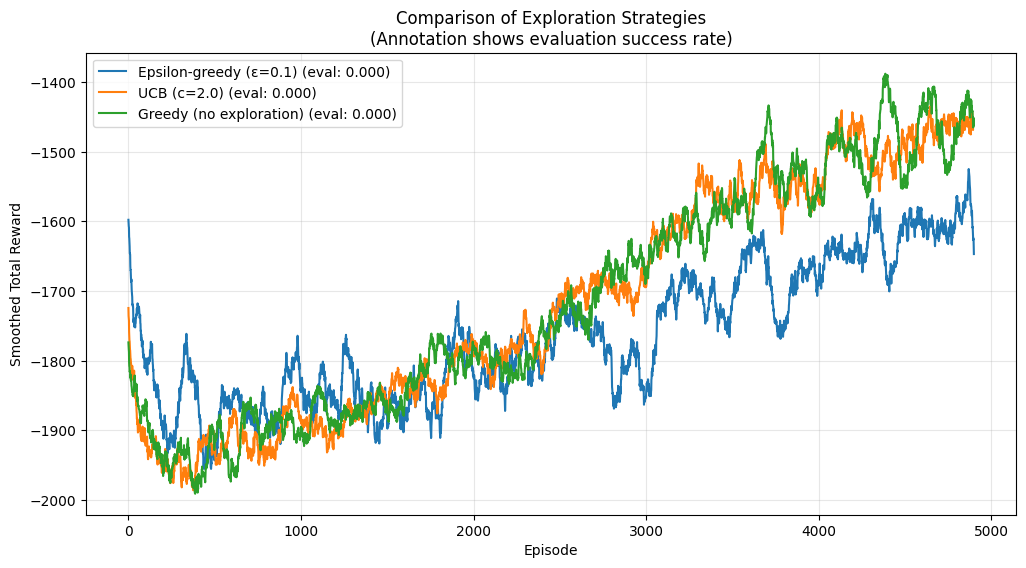

In [21]:
def compare_exploration_strategies():
    print("Comparing exploration strategies with proper evaluation...")
    
    strategies = {
        'Epsilon-greedy (ε=0.1)': lambda env: RLAgent(env, num_episodes=5000, epsilon=0.1, alpha=0.1, gamma=0.99),
        'UCB (c=2.0)': lambda env: UCBAgent(env, num_episodes=5000, alpha=0.1, gamma=0.99, c=2.0),
        'Greedy (no exploration)': lambda env: RLAgent(env, num_episodes=5000, epsilon=0.0, alpha=0.1, gamma=0.99)
    }
    
    results = {}
    
    for name, agent_creator in strategies.items():
        print(f"\nTraining {name}...")
        
        # Train the agent
        env_train = CliffBoxGridWorld()
        agent = agent_creator(env_train)
        rewards = agent.learn()
        
        # Evaluate properly (run multiple episodes without exploration)
        success_count = 0
        total_eval_episodes = 100
        
        for eval_ep in range(total_eval_episodes):
            env_eval = CliffBoxGridWorld()
            state = env_eval.reset()
            done = False
            success = False
            
            while not done and env_eval.timesteps < 50:  # Limit steps
                action = agent.act(state, is_training=False)  # No exploration during eval
                next_state, reward, done, info = env_eval.step(action)
                state = next_state
                
                if all(env_eval.box_pos == env_eval.goal_pos):
                    success = True
                    break
            
            if success:
                success_count += 1
        
        success_rate = success_count / total_eval_episodes
        results[name] = {
            'training_rewards': rewards,
            'eval_success_rate': success_rate,
            'agent': agent
        }
        
        print(f"{name} - Evaluation success rate: {success_rate:.3f}")
    
    return results

# Run the comparison
results = compare_exploration_strategies()

# Plot comparison
plt.figure(figsize=(12, 6))

# Smooth rewards for better visualization
def smooth_rewards(rewards, window=100):
    if len(rewards) < window:
        return rewards
    return np.convolve(rewards, np.ones(window)/window, mode='valid')

for name, result in results.items():
    smoothed = smooth_rewards(result['training_rewards'])
    plt.plot(range(len(smoothed)), smoothed, label=f'{name} (eval: {result["eval_success_rate"]:.3f})')

plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.title('Comparison of Exploration Strategies\n(Annotation shows evaluation success rate)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training sparse reward agent...


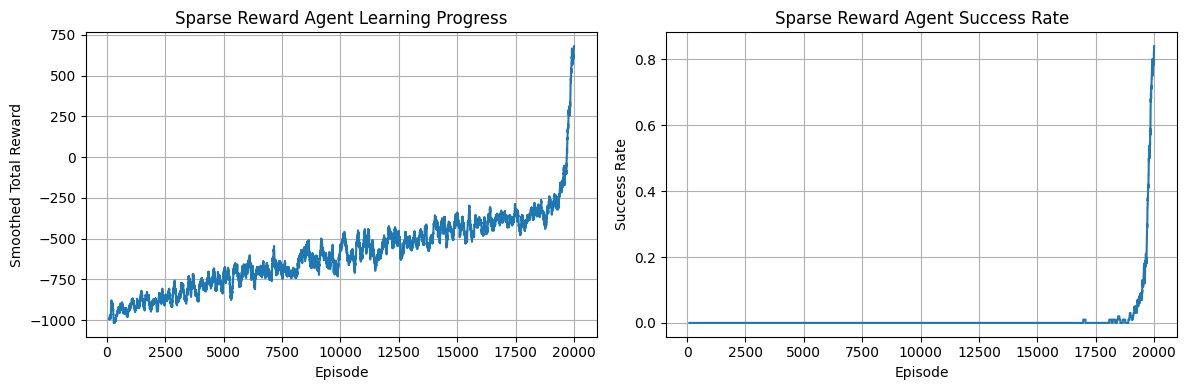

Sparse reward agent success rate: 1.000


In [ ]:
# Sparse reward agent
print("Training sparse reward agent...")
env_sparse = CliffBoxGridWorld()
agent_sparse = SparseRewardAgent(env_sparse, num_episodes=20000, epsilon=0.2, alpha=0.1, gamma=0.99)
rewards_sparse = agent_sparse.learn()

# Plot sparse reward learning
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
window_size = 100
smoothed_sparse = np.convolve(rewards_sparse, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size-1, len(rewards_sparse)), smoothed_sparse)
plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.title('Sparse Reward Agent Learning Progress')
plt.grid(True)

plt.subplot(1, 2, 2)
success_rates_sparse = []
for i in range(window_size, len(rewards_sparse)):
    success_rate = np.sum(np.array(rewards_sparse[i-window_size:i]) > 0) / window_size
    success_rates_sparse.append(success_rate)

plt.plot(range(window_size, len(rewards_sparse)), success_rates_sparse)
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.title('Sparse Reward Agent Success Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate sparse reward agent
success_count_sparse = 0
for i in range(500):
    state = env_sparse.reset()
    done = False
    
    while not done:
        action = agent_sparse.act(state, is_training=False)
        next_state, reward, done, info = env_sparse.step(action)
        state = next_state
    
    if reward > 0:
        success_count_sparse += 1

print(f"Sparse reward agent success rate: {success_count_sparse/500:.3f}")


Evaluate the agent without exploration

In [ ]:
env = CliffBoxGridWorld(render=True)
total_run = 1000
success = 0

for i in range(total_run):
    state = env.reset()
    done = False
    rewards = []
    
    while not done: 
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env.step(action)
        state = next_state
        rewards.append(reward)
    if sum(rewards) > 0:
        success += 1
print(success/total_run)

1.0


Evaluate the agent with exploration and visualization

In [ ]:
env = CliffBoxGridWorld(render=True)
state = env.reset()
env.print_world()
done = False
rewards = []

while not done: # Run until game terminated
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_' '_' 'x' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' '_' '_' '_' '_' 'x' 'x' '_']
 ['_' 'B' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' 'G']
 ['A' '_' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' '_']]
step: 1, state: (5, 1, 4, 1), actions: 4, reward: -14
Action: 4
[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_' '_' 'x' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' '_' '_' '_' '_' 'x' 'x' '_']
 ['_' 'B' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' 'G']
 ['_' 'A' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' '_']]
step: 2, state: (4, 1, 3, 1), actions: 1, reward: -15
Action: 1
[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_